In [471]:
%pip install matplotlib --quiet
%pip install numpy --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [472]:
import matplotlib.pyplot as plt
import numpy as np
import random

from src.guloso import labirinto_gulosos
from src.backtracking import labirinto_backtracking

In [473]:
def gerar_labirinto(linhas, colunas):
    # Garante que as dimensões sejam ímpares
    if linhas % 2 == 0:
        linhas += 1
    if colunas % 2 == 0:
        colunas += 1

    # Inicializa o labirinto todo com paredes (1)
    labirinto = [[1 for _ in range(colunas)] for _ in range(linhas)]

    # Gera a lista de células válidas para caminhos (ímpares)
    def vizinhos_validos(x, y):
        vizinhos = []
        for dx, dy in [(-2, 0), (2, 0), (0, -2), (0, 2)]:
            nx, ny = x + dx, y + dy
            if 1 <= nx < linhas - 1 and 1 <= ny < colunas - 1:
                if labirinto[nx][ny] == 1:
                    vizinhos.append((nx, ny))
        random.shuffle(vizinhos)
        return vizinhos

    def dfs(x, y):
        labirinto[x][y] = 0
        for nx, ny in vizinhos_validos(x, y):
            if labirinto[nx][ny] == 1:
                # Quebra a parede entre a célula atual e a nova
                labirinto[(x + nx) // 2][(y + ny) // 2] = 0
                dfs(nx, ny)
    
    # Define entrada
    entrada_x = random.randrange(1, linhas - 1, 2)
    entrada_y = 0  # A entrada está na borda esquerda
    labirinto[entrada_x][entrada_y] = 0

    # Define uma saída garantida na borda direita
    saida_x = random.randrange(1, linhas - 1, 2)
    saida_y = colunas - 1
    
    # Inicia DFS a partir da entrada para garantir um caminho principal
    dfs(entrada_x, 1)
    
    # Garante que existe pelo menos uma saída acessível
    labirinto[saida_x][saida_y] = 0
    
    # Se a célula adjacente à saída for parede, cria uma passagem
    if labirinto[saida_x][saida_y - 1] == 1:
        labirinto[saida_x][saida_y - 1] = 0
    
    # Adiciona passagens extras aleatórias para criar ramificações
    def adicionar_passagens_extras(tentativas=0.05):
        total = int(linhas * colunas * tentativas)
        for _ in range(total):
            x = random.randrange(1, linhas - 1, 2)
            y = random.randrange(1, colunas - 1, 2)
            dirs = [(0, 1), (1, 0), (0, -1), (-1, 0)]
            random.shuffle(dirs)
            for dx, dy in dirs:
                nx, ny = x + dx, y + dy
                if 0 < nx < linhas - 1 and 0 < ny < colunas - 1:
                    if labirinto[nx][ny] == 1:
                        labirinto[nx][ny] = 0
                        break

    adicionar_passagens_extras()
    
    # Adiciona saídas aleatórias adicionais na borda direita
    saidas = [(saida_x, saida_y)]  # Já inclui a saída garantida
    # for i in range(1, linhas - 1, 2):
    #     # Pula a saída já definida
    #     if i == saida_x:
    #         continue
            
    #     # 25% de chance de criar uma saída adicional
    #     if random.random() < 0.25 and labirinto[i][colunas - 2] == 0:
    #         labirinto[i][colunas - 1] = 0
    #         saidas.append((i, colunas - 1))
    
    return labirinto, (entrada_x, entrada_y), saidas

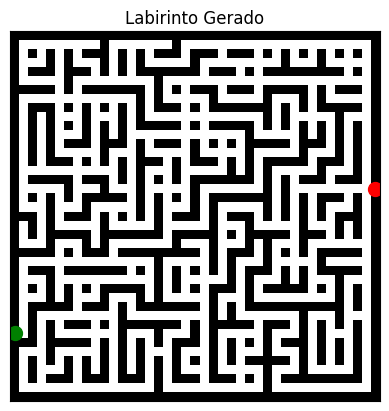

In [474]:
def plot_maze(maze, entrance, saidas):
    maze_array = np.array(maze)
    plt.imshow(maze_array, cmap='binary', interpolation='nearest')
    plt.xticks([]), plt.yticks([])
    plt.gca().invert_yaxis()
    
    plt.scatter(entrance[1], entrance[0], color='green', label='Entrada', s=100)
    for end in saidas:
        plt.scatter(end[1], end[0], color='red', label='Saída', s=100)
    
    
    plt.title('Labirinto Gerado')
    plt.show()
    
    
maze, start, ends = gerar_labirinto(41, 41)
plot_maze(maze, start, ends)

In [475]:
def caminho_guloso(maze, start, end):
    caminho = []
    visitado = [[False]*len(maze[0]) for _ in range(len(maze))]
    labirinto_gulosos(maze, start[0], start[1], caminho, visitado, end)
    return caminho

def caminho_backtracking(maze, start, end):
    caminho = []
    visitado = [[False]*len(maze[0]) for _ in range(len(maze))]
    labirinto_backtracking(maze, start[0], start[1], caminho, visitado, end)
    return caminho

In [476]:
def plot_maze(maze, caminho_guloso, caminho_backtracking, start, end):
    maze_array = np.array(maze)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    
    ax1.imshow(maze_array, cmap='binary', interpolation='nearest')
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.invert_yaxis()
    
    for (x, y) in caminho_guloso:
        ax1.scatter(y, x, color='blue', s=20)
    
    ax1.scatter(start[1], start[0], color='green', s=100)
    ax1.scatter(end[1], end[0], color='red', s=100)
    ax1.set_title('Algoritmo Guloso')
    
    ax2.imshow(maze_array, cmap='binary', interpolation='nearest')
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.invert_yaxis()

    for (x, y) in caminho_backtracking:
        ax2.scatter(y, x, color='orange', s=20)
    
    ax2.scatter(start[1], start[0], color='green', s=100)
    ax2.scatter(end[1], end[0], color='red', s=100)
    ax2.set_title('Algoritmo Backtracking')
    
    plt.tight_layout()
    plt.show()


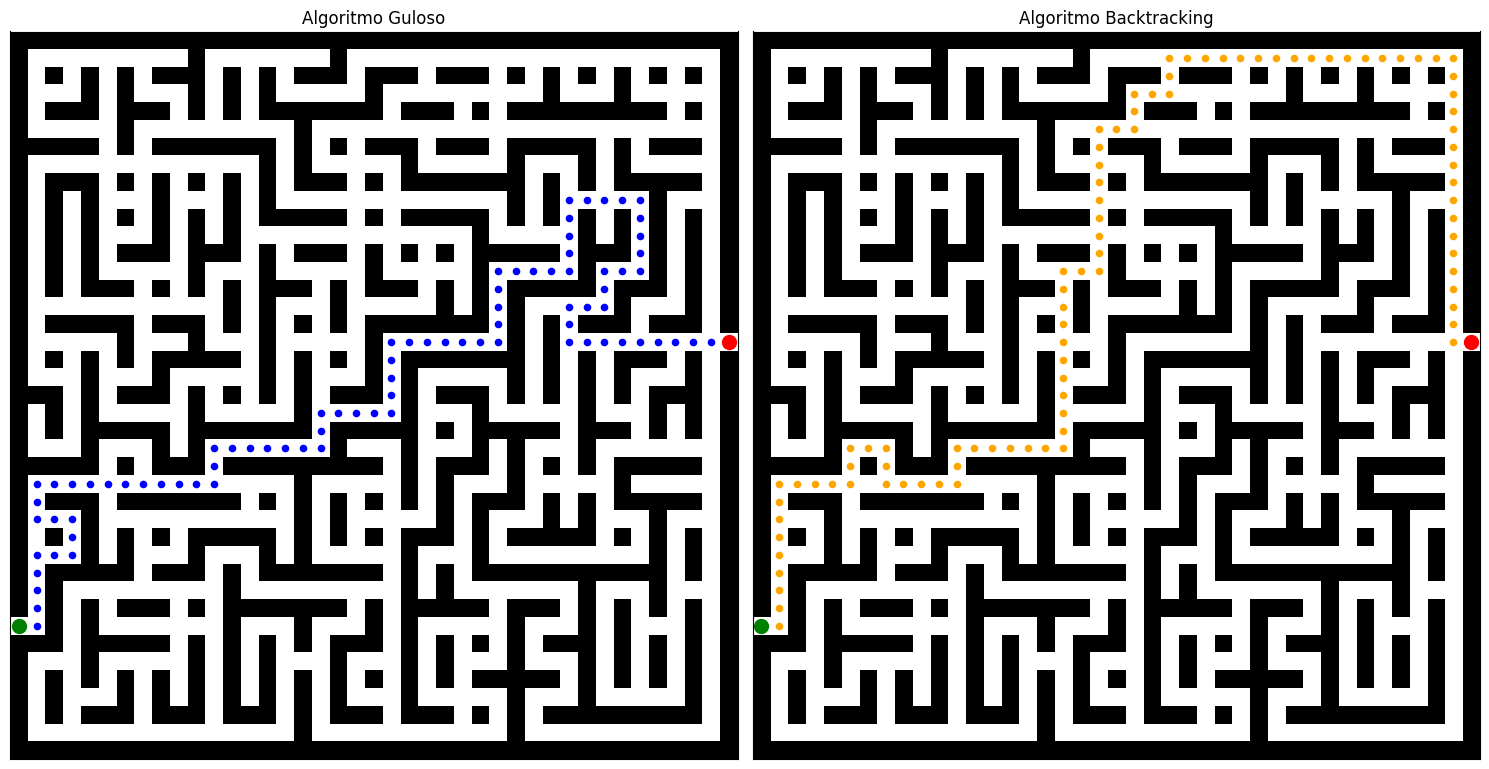

In [477]:

args_cam = (maze, start, ends[0])
args_plt = (start, ends[0])
plot_maze(maze, caminho_guloso(*args_cam), caminho_backtracking(*args_cam), *args_plt)